Similar process as in "Prediction.ipynb"

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Split and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model to use
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#hyperparameter tuning with random search and grid search
from sklearn.model_selection import PredefinedSplit # use for searching
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


# evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix

In [4]:
df = pd.read_csv('with_claim_values.csv')
df.head()

,AccidentArea,Sex,Age,Fault,VehiclePrice,FraudFound_P,RepNumber,Deductible,DriverRating,Days_Policy_Accident,...,VehicleCategory_Sport,VehicleCategory_Utility,BasePolicy_All Perils,BasePolicy_Collision,BasePolicy_Liability,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,Claim_values
0,0,1,21,0,5.0,0,12,300,1,4.0,...,1,0,0,0,1,0,0,1,0,3928
1,0,0,34,0,5.0,0,15,400,4,4.0,...,1,0,0,1,0,0,0,1,0,5066
2,0,0,47,0,5.0,0,7,400,3,4.0,...,1,0,0,1,0,0,1,0,0,5123
3,1,0,65,1,1.0,0,4,400,2,4.0,...,1,0,0,0,1,0,1,0,0,1382
4,0,1,27,1,5.0,0,3,400,1,4.0,...,1,0,0,1,0,0,0,1,0,4639


In [5]:
# input
X = df.drop(columns=['FraudFound_P'])

# target
y = df['FraudFound_P']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train and X_test includes claim values that needed to be exclued

In [7]:
values_train = X_train['Claim_values']
X_train = X_train.drop(columns=['Claim_values'])

values_val = X_val['Claim_values']
X_val = X_val.drop(columns=['Claim_values'])

values_test = X_test['Claim_values']
X_test = X_test.drop(columns=['Claim_values'])

Scaling

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("Training set size:", X_train.shape)
print("Development set size:", X_val.shape)
print("Testing set size:", X_test.shape)

Training set size: (9252, 61)
Development set size: (3084, 61)
Testing set size: (3084, 61)


Using cost-senitive XGBoost

In [9]:
# Combine the training and validation data back into a single dataset for searching
X_combinedCS = np.vstack((X_train, X_val))
y_combinedCS = np.hstack((y_train, y_val))

# Create the split index (training instances as -1, validation instances as 0): predefined val
split_index = [-1] * len(X_train) + [0] * len(X_val)
pdsCS = PredefinedSplit(test_fold=split_index)

In [10]:
# Parameter grid for XGBoost
random_grid_XGB = {
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [int(x) for x in np.linspace(3, 10, num=8)],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0.0, 0.1, 0.2, 0.5, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Compute scale_pos_weight
scale_pos_weight = len(y_train[y == 0]) / len(y_train[y == 1])
# XGBoost classifier
csxgb = XGBClassifier(use_label_encoder=False, scale_pos_weight=scale_pos_weight,eval_metric='logloss')

# RandomizedSearchCV setup
csxgb_random = RandomizedSearchCV(estimator=csxgb, param_distributions=random_grid_XGB, 
                                n_iter=100, cv=pdsCS, verbose=2, random_state=42, n_jobs=-1, scoring='f1_weighted')

csxgb_random.fit(X_combinedCS, y_combinedCS)

print("Best parameters found: ", csxgb_random.best_params_)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.8, gamma=1.0, learning_rate=0.01, max_depth=10, min_child_weight=4, n_estimators=100, subsample=0.8; total time=   0.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=200, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=600, subsample=0.8; total time=   0.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=9, min_child_weight=1, n_estimators=800, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=600, subsample=0.6; total time=   1.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=9, min_child_weight=2, n_estimators=700, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=700, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=8, min_child_weight=4, n_estimators=900, subsample=0.6; total time=   1.5s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=800, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.05, max_depth=7, min_child_weight=1, n_estimators=900, subsample=0.8; total time=   2.0s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:29:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=700, subsample=1.0; total time=   2.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=600, subsample=0.6; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=800, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=400, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=4, n_estimators=300, subsample=1.0; total time=   0.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   1.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=500, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=700, subsample=0.8; total time=   2.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=700, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=500, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=900, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.05, max_depth=7, min_child_weight=4, n_estimators=700, subsample=1.0; total time=   1.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=800, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=4, n_estimators=600, subsample=1.0; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.05, max_depth=10, min_child_weight=4, n_estimators=100, subsample=1.0; total time=   0.3s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.01, max_depth=4, min_child_weight=4, n_estimators=900, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=300, subsample=0.8; total time=   0.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.3, max_depth=9, min_child_weight=2, n_estimators=400, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=2, n_estimators=700, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=900, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=600, subsample=1.0; total time=   0.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=800, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.3, max_depth=10, min_child_weight=2, n_estimators=400, subsample=1.0; total time=   0.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=6, min_child_weight=2, n_estimators=400, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.1, max_depth=9, min_child_weight=4, n_estimators=1000, subsample=1.0; total time=   0.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.1, max_depth=9, min_child_weight=4, n_estimators=800, subsample=0.6; total time=   1.8s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=600, subsample=0.6; total time=   1.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=600, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.1, max_depth=5, min_child_weight=4, n_estimators=1000, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=4, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=600, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=9, min_child_weight=4, n_estimators=900, subsample=0.6; total time=   2.3s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.8, gamma=1.0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=300, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=600, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=600, subsample=0.6; total time=   0.9s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.01, max_depth=10, min_child_weight=4, n_estimators=700, subsample=0.6; total time=   2.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=10, min_child_weight=2, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=900, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=600, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500, subsample=1.0; total time=   0.6s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=800, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=4, n_estimators=600, subsample=0.6; total time=   1.1s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.2, max_depth=6, min_child_weight=2, n_estimators=1000, subsample=0.6; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=2, n_estimators=900, subsample=1.0; total time=   0.9s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=4, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.05, max_depth=5, min_child_weight=4, n_estimators=500, subsample=1.0; total time=   0.7s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=8, min_child_weight=4, n_estimators=400, subsample=0.6; total time=   1.0s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.1, max_depth=6, min_child_weight=4, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=1000, subsample=0.6; total time=   1.3s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, n_estimators=1000, subsample=0.8; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=200, subsample=0.6; total time=   0.4s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=10, min_child_weight=2, n_estimators=800, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=900, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, subsample=0.6; total time=   0.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=6, min_child_weight=4, n_estimators=300, subsample=1.0; total time=   0.6s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=300, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=300, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=700, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.3, max_depth=7, min_child_weight=2, n_estimators=400, subsample=0.6; total time=   0.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=900, subsample=0.6; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=1000, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=700, subsample=1.0; total time=   1.0s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=4, n_estimators=200, subsample=0.8; total time=   0.5s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.1, max_depth=9, min_child_weight=2, n_estimators=900, subsample=0.8; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.3s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=1.0, learning_rate=0.2, max_depth=7, min_child_weight=4, n_estimators=500, subsample=0.6; total time=   0.8s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.01, max_depth=10, min_child_weight=4, n_estimators=200, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=800, subsample=0.6; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=800, subsample=0.6; total time=   1.7s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=8, min_child_weight=4, n_estimators=800, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=1.0, gamma=1.0, learning_rate=0.2, max_depth=7, min_child_weight=2, n_estimators=100, subsample=1.0; total time=   0.2s


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, max_depth=6, min_child_weight=2, n_estimators=600, subsample=0.6; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=2, n_estimators=900, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=400, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.05, max_depth=9, min_child_weight=2, n_estimators=900, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.01, max_depth=7, min_child_weight=2, n_estimators=1000, subsamp

/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [09:30:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'subsample': 1.0, 'n_estimators': 600, 'min_child_weight': 4, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.6}


In [11]:
# XGB
cs_xgb = csxgb_random.best_estimator_
cs_xgb_prob = cs_xgb.predict_proba(X_test)[:,1]


cs_xgb_prob

array([7.4776605e-04, 1.7865095e-05, 1.3105523e-02, ..., 4.0574145e-04,
       1.7610640e-04, 6.4079762e-02], dtype=float32)

In [12]:
df_mpt_test = pd.DataFrame()

# fraud or not
df_mpt_test['fraud'] = y_test
# prob of a claim being fraud
df_mpt_test['prob'] = cs_xgb_prob
# claim values
df_mpt_test['values'] = values_test

df_mpt_test.head(50)

,fraud,prob,values
4291,0,7.477661e-04,7618
7874,0,1.786510e-05,2028
3325,0,1.310552e-02,1660
4048,0,4.115597e-01,2243
15203,0,3.566841e-02,1274
8013,0,1.513784e-02,561
11277,0,8.121387e-04,1911
11484,0,6.313804e-05,9914
6323,0,1.060579e-02,1557
13663,0,1.470988e-04,3679


In [42]:
df_mpt_test['risk_i'] = 1 - df_mpt_test['prob']

df_mpt_test

,fraud,prob,values,risk_i
4291,0,0.000748,7618,0.999252
7874,0,0.000018,2028,0.999982
3325,0,0.013106,1660,0.986894
4048,0,0.411560,2243,0.588440
15203,0,0.035668,1274,0.964332
...,...,...,...,...
9747,0,0.000139,5804,0.999861
8574,0,0.007813,3629,0.992187
6408,0,0.000406,1927,0.999594
5438,0,0.000176,5573,0.999824


## Value-return optimisation (similar to MPT)
objective: Find $W^*$ = $Argmax_{W} \mathcal{O}(W; P, R)$
given $n$ claims in each portfolio
$W^*, W \in \mathbb{R}^n$

#### 1. Objective Function, $\mathcal{O}$ : 
- Expected Return: $\sum_i^n w_i P_i R_i$

- Modified Objective function $\sum_i^n w_i P_i^2 R_i$, using $P^2$ to penaltise smalle probabilities to provide more risk-averse allocation

#### 2. Risk Constraints: 

- Using Monte Carlo to Find the successful rate and set a treshold $\alpha$: $\mathbb{P}(WR > Risklevel) > \alpha$, $WR, Risklevel, \alpha \in [0,1]$. 
- Interpretation of $\alpha$: The threshold of the probability of the successful rate of the whole portfolio larger than a given risk level

One can think of this as a weighted probability version of Poisson Binomial. However, probability cannot be directly modified by multiplying weights, so Monte Carlo simulation was used instead.

#### Drawbacks: 
- Can be slow

In [82]:
import numpy as np

# Set the number of simulations
n_simulations = 100000

# Probabilities and weights for each event
probabilities = np.array([0.5, 0.3, 0.2])  # Probabilities for A, B, C
weights = np.array([0.4, 0.3, 0.3])        # Weights for A, B, C

# Simulation of outcomes
outcomes = np.random.rand(n_simulations, 3) < probabilities

# Calculate weighted sums for each simulation
weighted_sums = np.dot(outcomes, weights)

# Calculate probabilities
p_w_greater_0_7 = np.mean(weighted_sums > 0.7)
p_w_equals_0_7 = np.mean(weighted_sums == 0.7)
p_w_equals_1_0 = np.mean(weighted_sums == 1.0)

print(f"Probability P(W > 0.7): {p_w_greater_0_7:.4f}")
print(f"Probability P(W = 0.7): {p_w_equals_0_7:.4f}")
print(f"Probability P(W = 1.0): {p_w_equals_1_0:.4f}")

Probability P(W > 0.7): 0.0300
Probability P(W = 0.7): 0.1889
Probability P(W = 1.0): 0.0300


In [83]:
import numpy as np

# Simulation parameters
n_simulations = 100000
weights = np.array([0.4, 0.3, 0.3])
probabilities = np.array([0.1, 0.2, 0.15])

# Simulate outcomes
outcomes = np.random.rand(n_simulations, 3) < probabilities
weighted_risks = np.dot(outcomes, weights)

# Analyzing the results
risk_levels = np.unique(weighted_risks)
risk_probabilities = {level: np.mean(weighted_risks == level) for level in risk_levels}

print("Risk Levels and Their Probabilities:")
for risk, prob in risk_probabilities.items():
    print(f"Risk Level {risk:.2f}: Probability {prob:.4f}")

Risk Levels and Their Probabilities:
Risk Level 0.00: Probability 0.6093
Risk Level 0.30: Probability 0.2629
Risk Level 0.40: Probability 0.0685
Risk Level 0.60: Probability 0.0269
Risk Level 0.70: Probability 0.0294
Risk Level 1.00: Probability 0.0031


In [84]:
import numpy as np

def calculate_portfolio_metrics(weights, probabilities, values, n_simulations=100000):
    """
    Calculate the risk distribution and expected return of a portfolio.

    Parameters:
    - weights (numpy array): The weights of each asset in the portfolio.
    - probabilities (numpy array): The probability of each asset achieving a positive outcome.
    - values (numpy array): The expected returns of each asset if the positive outcome occurs.
    - n_simulations (int): The number of simulations to perform.

    Returns:
    - dict: A dictionary containing the expected return and a dictionary of risk levels and their probabilities.
    """
    # Simulate outcomes based on probabilities
    outcomes = np.random.rand(n_simulations, len(weights)) < probabilities
    
    # Calculate weighted risks for each simulation
    weighted_risks = np.dot(outcomes, weights)
    
    # Calculate risk distribution
    risk_levels = np.unique(weighted_risks)
    risk_probabilities = {level: np.mean(weighted_risks == level) for level in risk_levels}
    
    # Calculate expected return
    expected_return = np.sum(weights * probabilities * values)
    
    return {'Expected Return': expected_return, 'Risk Distribution': risk_probabilities}

# Example usage
weights = np.array([0.4, 0.3, 0.3])
probabilities = np.array([0.8, 0.6, 0.9])
values = np.array([10, 20, 15])  # Example values could be percentage returns or similar metrics

portfolio_metrics = calculate_portfolio_metrics(weights, probabilities, values)

print("Expected Portfolio Return:", portfolio_metrics['Expected Return'])
print("Risk Levels and Their Probabilities:")
for risk, prob in portfolio_metrics['Risk Distribution'].items():
    print(f"  Risk Level {risk:.2f}: Probability {prob:.4f}")

Expected Portfolio Return: 10.850000000000001
Risk Levels and Their Probabilities:
  Risk Level 0.00: Probability 0.0079
  Risk Level 0.30: Probability 0.0850
  Risk Level 0.40: Probability 0.0330
  Risk Level 0.60: Probability 0.1085
  Risk Level 0.70: Probability 0.3328
  Risk Level 1.00: Probability 0.4328


In [85]:
import numpy as np
from scipy.optimize import minimize

# Simulate the risk distribution for a given set of weights
def simulate_risk(weights, probabilities, n_simulations=100000):
    outcomes = np.random.rand(n_simulations, len(weights)) < probabilities
    weighted_risks = np.dot(outcomes, weights)
    return weighted_risks

# Objective function: Negative expected return (since we want to maximize)
def negative_expected_return(weights, probabilities, values):
    return -np.dot(weights, probabilities * values)

# Constraint on the CDF
def cdf_constraint(weights, target_risk_level, alpha, probabilities):
    risks = simulate_risk(weights, probabilities)
    return alpha - np.mean(risks > target_risk_level)

# Example parameters
probabilities = np.array([0.8, 0.6, 0.9])
values = np.array([10, 20, 15])
target_risk_level = 0.7
alpha = 0.8  # Maximum acceptable probability of exceeding the risk level

# Initial weights (equal allocation)
initial_weights = np.array([1/3, 1/3, 1/3])

# Constraints and bounds
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # weights sum to 1
        {'type': 'ineq', 'fun': lambda w: cdf_constraint(w, target_risk_level, alpha, probabilities)})  # CDF constraint
bounds = [(0, 1) for _ in range(len(probabilities))]

# Run the optimization
result = minimize(negative_expected_return, initial_weights, args=(probabilities, values), 
                  constraints=cons, bounds=bounds, method='SLSQP')

if result.success:
    optimal_weights = result.x
    print("Optimal Weights:", optimal_weights)
    print("Expected Return:", -result.fun)
else:
    print("Optimization failed:", result.message)

Optimization failed: Iteration limit reached


In [43]:
import numpy as np
from scipy.optimize import minimize

def simulate_risk(weights, probabilities, n_simulations=100000):
    """Simulate the risk distribution for a given set of weights."""
    outcomes = np.random.rand(n_simulations, len(weights)) < probabilities
    weighted_risks = np.dot(outcomes, weights)
    return weighted_risks

def negative_expected_return(weights, probabilities, values):
    """Calculate the negative of the expected return to use in minimization."""
    return -np.dot(weights, probabilities * values)

def cdf_constraint(weights, target_risk_level, alpha, probabilities):
    """Constraint function that the CDF of the risk must be less than alpha at the target risk level."""
    risks = simulate_risk(weights, probabilities)
    return alpha - np.mean(risks > target_risk_level)

# Define parameters
probabilities = np.array([0.8, 0.6, 0.9])  # Probabilities of positive outcomes
values = np.array([10, 20, 15])            # Expected values or returns of assets
target_risk_level = 0.7                    # Target risk level
alpha = 0.1                                # Maximum acceptable probability of exceeding the risk level

# Initial weights (better guess based on heuristic or prior knowledge)
initial_weights = np.array([0.5, 0.25, 0.25])

# Constraints and bounds
cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Weights must sum to 1
        {'type': 'ineq', 'fun': lambda w: cdf_constraint(w, target_risk_level, alpha, probabilities)}]
bounds = [(0, 1) for _ in range(len(probabilities))]

options = {'maxiter': 10000, 'disp': True}  # Provide more iterations and display diagnostics

result = minimize(negative_expected_return, initial_weights, args=(probabilities, values),
                  constraints=cons, bounds=bounds, method='TNC', options=options)

print(result)

# Output the results
if result.success:
    optimal_weights = result.x
    print("Optimization succeeded.")
    print("Optimal Weights:", optimal_weights)
    print("Expected Portfolio Return:", -result.fun)
else:
    print("Optimization failed:", result.message)

     fun: -33.5
     jac: array([ -7.99999991, -11.99999951, -13.49999998])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 28
     nit: 3
  status: 0
 success: True
       x: array([1., 1., 1.])
Optimization succeeded.
Optimal Weights: [1. 1. 1.]
Expected Portfolio Return: 33.5


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/scipy/optimize/_minimize.py:541: RuntimeWarning: Method TNC cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
  NIT   NF   F                       GTG
    0    1 -1.037500000000000E+01   3.90249999E+02
    1    4 -3.205555542178054E+01   2.07999975E+02
    2    6 -3.349999995394630E+01   6.39999986E+01
    3    8 -3.350000000000000E+01   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    3    8 -3.350000000000000E+01   0.00000000E+00
tnc: Local minima reach (|pg| ~= 0)


In [69]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import Bounds, minimize, LinearConstraint

def simulate_risk(weights, probabilities, n_simulations=1000000):
    """Simulate the risk distribution for a given set of weights."""
    outcomes = np.random.rand(n_simulations, len(weights)) < probabilities
    weighted_risks = np.dot(outcomes, weights)
    return weighted_risks

def negative_expected_return(weights, probabilities, values):
    """Calculate the negative of the expected return to use in minimization."""
    return -np.dot(weights, probabilities *  values)

def cdf_constraint(weights, target_risk_level, alpha, probabilities):
    """Constraint function that the CDF of the risk must be less than alpha at the target risk level."""
    risks = simulate_risk(weights, probabilities)
    return np.mean(risks > target_risk_level) - alpha

# Define parameters
probabilities = np.array([0.1, 0.5, 0.9])  # Probabilities of positive outcomes
values = np.array([900, 180, 100])            # Expected values or returns of assets
target_risk_level = 0.7                  # Target risk level
alpha = 0.9                               # Maximum acceptable probability of exceeding the risk level

# Initial weights (start with an equal allocation)
initial_weights = np.array([1/3, 1/3, 1/3])

# Constraints and bounds
cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Ensure weights sum to 1
        {'type': 'ineq', 'fun': lambda w: cdf_constraint(w, target_risk_level, alpha, probabilities)}]
# Update bounds and constraints
bounds = Bounds([0, 0, 0], [1, 1, 1])  # Ensures all weights are between 0 and 1
linear_constraint = LinearConstraint([1, 1, 1], [1], [1])  # Ensures weights sum to 1

# Using 'trust-constr' method
result = minimize(
    negative_expected_return, initial_weights, args=(probabilities, values),
    method='trust-constr', constraints=[linear_constraint, {'type': 'ineq', 'fun': lambda w: cdf_constraint(w, target_risk_level, alpha, probabilities)}],
    bounds=bounds, options={'verbose': 2, 'maxiter': 10000}
)

# Print results
print(result)

# Output the results
if result.success:
    optimal_weights = result.x
    print("Optimization succeeded.")
    print("Optimal Weights:", optimal_weights)
    print("Expected Portfolio Return:", -result.fun)
else:
    print("Optimization failed:", result.message)


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   4   |   0   | -9.0000e+01 | 1.00e+00 | 4.72e-05 | 8.55e-01 |
|   2   |   8   |   1   | -9.0000e+01 | 5.00e-01 | 4.72e-05 | 8.55e-01 |
|   3   |  12   |   2   | -9.0000e+01 | 2.50e-01 | 4.72e-05 | 8.55e-01 |


/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|   4   |  16   |   3   | -9.0000e+01 | 1.25e-01 | 4.72e-05 | 8.55e-01 |
|   5   |  20   |   4   | -9.0000e+01 | 6.25e-02 | 4.72e-05 | 8.55e-01 |
|   6   |  24   |   5   | -9.0000e+01 | 3.12e-02 | 4.72e-05 | 8.55e-01 |
|   7   |  28   |   6   | -9.0000e+01 | 1.56e-02 | 4.72e-05 | 8.55e-01 |
|   8   |  32   |   7   | -9.0000e+01 | 7.81e-03 | 4.72e-05 | 8.55e-01 |
|   9   |  36   |   8   | -9.0000e+01 | 3.91e-03 | 4.72e-05 | 8.55e-01 |
|  10   |  40   |   9   | -9.0000e+01 | 1.95e-03 | 4.72e-05 | 8.55e-01 |
|  11   |  44   |  10   | -9.0000e+01 | 9.77e-04 | 4.72e-05 | 8.55e-01 |
|  12   |  48   |  11   | -9.0000e+01 | 4.88e-04 | 4.72e-05 | 8.55e-01 |
|  13   |  52   |  12   | -9.0000e+01 | 2.44e-04 | 4.72e-05 | 8.55e-01 |
|  14   |  56   |  13   | -9.0000e+01 | 1.22e-04 | 4.72e-05 | 8.55e-01 |
|  15   |  60   |  14   | -9.0000e+01 | 6.10e-05 | 4.72e-05 | 8.55e-01 |
|  16   |  64   |  15   | -9.0000e+01 | 3.05e-05 | 4.72e-05 | 8.55e-01 |
|  17   |  68   |  16   | -9.0000e+01 | 1.53e-05 | 

In [47]:
import numpy as np
from scipy.optimize import Bounds, minimize, LinearConstraint

def simulate_risk_and_returns(weights, probabilities, values, n_simulations=100000):
    """Simulate the risk and return distributions for a given set of weights."""
    outcomes = np.random.rand(n_simulations, len(weights)) < probabilities
    weighted_returns = np.dot(outcomes, weights * values)
    return weighted_returns

def expected_return_and_risk(weights, probabilities, values, lambda_risk):
    """Calculate the negative of the expected return and add variance as a risk measure."""
    returns = simulate_risk_and_returns(weights, probabilities, values)
    expected_return = np.mean(returns)
    risk_penalty = np.var(returns)
    return -expected_return + lambda_risk * risk_penalty

def cdf_constraint(weights, target_risk_level, alpha, probabilities, values):
    """Constraint function that the CDF of the risk must be less than alpha at the target risk level."""
    returns = simulate_risk_and_returns(weights, probabilities, values)
    return alpha - np.mean(returns > target_risk_level)

# Define parameters
probabilities = np.array([0.5, 0.5, 0.5])
values = np.array([900, 300, 100])
target_risk_level = 0.7
alpha = 0.1
lambda_risk = 0.5  # Risk aversion parameter

# Initial weights (start with an equal allocation)
initial_weights = np.array([1/3, 1/3, 1/3])

# Constraints and bounds
bounds = Bounds([0, 0, 0], [1, 1, 1])
linear_constraint = LinearConstraint([1, 1, 1], [1], [1])

# Using 'trust-constr' method
result = minimize(
    expected_return_and_risk, initial_weights, args=(probabilities, values, lambda_risk),
    method='trust-constr', constraints=[linear_constraint, {'type': 'ineq', 'fun': lambda w: cdf_constraint(w, target_risk_level, alpha, probabilities, values)}],
    bounds=bounds, options={'verbose': 2, 'maxiter': 10000}
)

# Print results
print(result)

# Output the results
if result.success:
    optimal_weights = result.x
    print("Optimization succeeded.")
    print("Optimal Weights:", optimal_weights)
    print("Expected Portfolio Return:", -result.fun - lambda_risk * np.var(simulate_risk_and_returns(optimal_weights, probabilities, values)))
else:
    print("Optimization failed:", result.message)


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   4   |   0   | +1.2441e+04 | 1.00e+00 | 2.52e+08 | 7.75e-01 |
|   2   |   8   |   1   | +4.9367e+03 | 1.00e+00 | 6.74e+07 | 7.74e-01 |
|   3   |  12   |   2   | +5.0211e+03 | 1.00e+00 | 1.06e+08 | 7.76e-01 |
|   4   |  16   |   4   | +5.0891e+03 | 2.00e+00 | 1.51e+07 | 7.74e-01 |
|   5   |  24   |   5   | +5.0891e+03 | 2.00e-01 | 1.51e+07 | 7.74e-01 |
|   6   |  28   |   7   | +5.0490e+03 | 2.00e-01 | 2.24e+06 | 7.76e-01 |
|   7   |  36   |   9   | +5.0490e+03 | 1.00e-01 | 2.24e+06 | 7.76e-01 |
|   8   |  44   |  11   | +5.0490e+03 | 5.00e-02 | 2.24e+06 | 7.76e-01 |
|   9   |  48   |  12   | +5.0665e+03 | 5.00e-02 | 6.71e+05 | 7.75e-01 |
|  10   |  52   |  13   | +5.0665e+03 | 5.00e-03 | 6.71e+05 | 7.75e-01 |
|  11   |  56   |  14   | +5.0665e+03 | 5.00e-04 | 6.71e+05 | 7.75e-01 |
|  12   |  60   |  15   | +5.0665e+03 | 5.00e-05 | 

In [51]:
import numpy as np

def monte_carlo_portfolio_simulation(weights, probabilities, values, n_simulations=10000):
    # Number of assets
    n_assets = len(weights)
    
    # Initialize an array to hold simulation results
    portfolio_outcomes = np.zeros(n_simulations)
    
    # Perform simulations
    for i in range(n_simulations):
        # Generate outcomes for each asset based on its probability of success
        outcomes = np.random.rand(n_assets) < probabilities
        
        # Calculate returns for each asset, outcomes are either 1 (success) or 0 (failure)
        asset_returns = outcomes * values
        
        # Calculate the portfolio return for this simulation
        portfolio_outcomes[i] = np.dot(weights, asset_returns)
    
    # Calculate expected return and risk (standard deviation)
    expected_return = np.mean(portfolio_outcomes)
    risk = np.std(portfolio_outcomes)
    
    return expected_return, risk

# Example usage
weights = np.array([0.4, 0.3, 0.3])  # Portfolio weights
probabilities = np.array([0.1, 0.5, 0.9])  # Probability of each asset succeeding
values = np.array([900, 100, 100])  # Return values for each asset

expected_return, risk = monte_carlo_portfolio_simulation(weights, probabilities, values)
print("Expected Portfolio Return:", expected_return)
print("Portfolio Risk (Std Dev):", risk)


Expected Portfolio Return: 79.11
Portfolio Risk (Std Dev): 110.88736582677036


In [54]:
import numpy as np

def bernoulli_sample(p):
    R = np.random.uniform(0, 1)  # Generate a random number from U(0,1)
    if R < p:
        return 1  # Success
    else:
        return 0  # Failure

# Example usage
p = 0.3  # Probability of success
sample = bernoulli_sample(p)
print("Sampled Value:", sample)

Sampled Value: 1


In [73]:
import numpy as np

def bernoulli_sample(p):
    R = np.random.uniform(0, 1)  # Generate a random number from U(0,1)
    if R < p:
        return 1 # success
    else:
        return 0  # fail
def simulate_bernoulli(p, n_trials):
    results = [bernoulli_sample(p) for _ in range(n_trials)]
    estimated_probability = sum(results) / n_trials
    return estimated_probability

# Example usage
p = 0.7  # Probability of success
n_trials = 10000  # Number of trials
estimated_p = simulate_bernoulli(p, n_trials)
print(f"Estimated Probability of Success: {estimated_p}")


Estimated Probability of Success: 0.7019


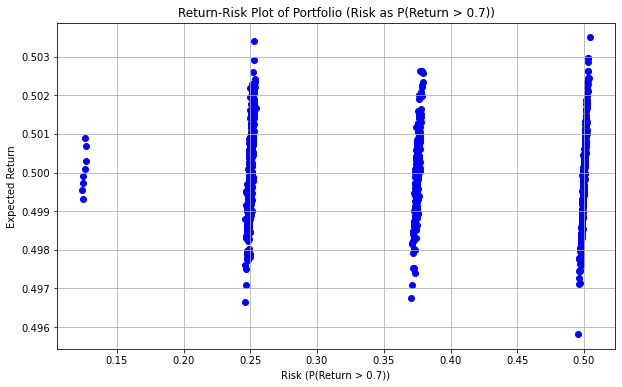

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import Bounds, minimize, LinearConstraint

def simulate_risk_and_returns(weights, probabilities, n_simulations=100000):
    """Simulate the risk and return distributions for a given set of weights."""
    outcomes = np.random.rand(n_simulations, len(weights)) < probabilities
    weighted_returns = np.dot(outcomes, weights)
    return weighted_returns

def generate_return_risk_plot(probabilities, values, target_risk_level, n_points=1000):
    np.random.seed(42)  # For reproducible results
    risk_values = []
    return_values = []

    # Generate random weights
    for _ in range(n_points):
        weights = np.random.dirichlet(np.ones(len(values)))  # Random weights that sum to 1
        returns = simulate_risk_and_returns(weights, probabilities)
        expected_return = np.mean(returns)
        risk = np.mean(returns > target_risk_level)  # Proportion of returns exceeding the target risk level

        risk_values.append(risk)
        return_values.append(expected_return)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(risk_values, return_values, c='blue', marker='o')
    plt.title(f'Return-Risk Plot of Portfolio (Risk as P(Return > {target_risk_level}))')
    plt.xlabel(f'Risk (P(Return > {target_risk_level}))')
    plt.ylabel('Expected Return')
    plt.grid(True)
    plt.show()

# Define parameters
probabilities = np.array([0.5, 0.5, 0.5])
values = np.array([900, 300, 100])
target_risk_level = 0.7  # Define a target risk level for the context

# Generate and display the return-risk plot
generate_return_risk_plot(probabilities, values, target_risk_level)


In [76]:
import numpy as np

def bernoulli_inverse_sample(p):
    U = np.random.uniform(0, 1)  # Generate a random number from U(0,1)
    return 1 if U >= 1 - p else 0

# Example usage
p = 0.7  # Probability of success
samples = [bernoulli_inverse_sample(p) for _ in range(1000)]
print("Number of Successes:", sum(samples)/1000)

Number of Successes: 0.724


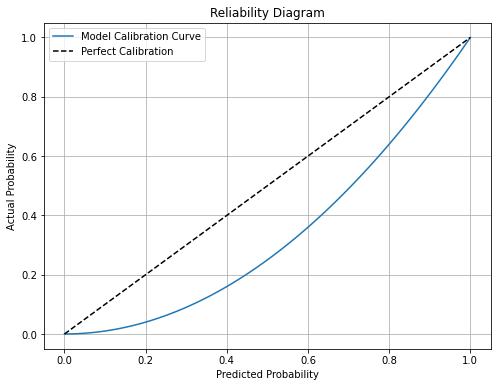

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Generating synthetic data for demonstration
predicted_probabilities = np.linspace(0, 1, 100)
actual_probabilities = predicted_probabilities**2  # Example where the classifier is underconfident

plt.figure(figsize=(8, 6))
plt.plot(predicted_probabilities, actual_probabilities, label='Model Calibration Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.title('Reliability Diagram')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate synthetic binary classification data
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train a RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Calibrate the model on the test set using isotonic regression
calibrated = CalibratedClassifierCV(base_estimator=model, method='isotonic', cv='prefit')
calibrated.fit(X_test, y_test)

# Predict probabilities on a range of synthetic scores (simulating model outputs)
predicted_scores = np.linspace(0, 1, 100)
calibrated_probs = calibrated.predict_proba(predicted_scores[:, None])[:, 1]

# Plotting the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(predicted_scores, calibrated_probs, label='Calibrated probabilities')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
plt.xlabel('Predicted score')
plt.ylabel('Probability of positive class')
plt.title('Calibration Curve Using Isotonic Regression')
plt.legend()
plt.grid(True)
plt.show()

/Users/chenyian/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


TypeError: None is not an estimator instance.

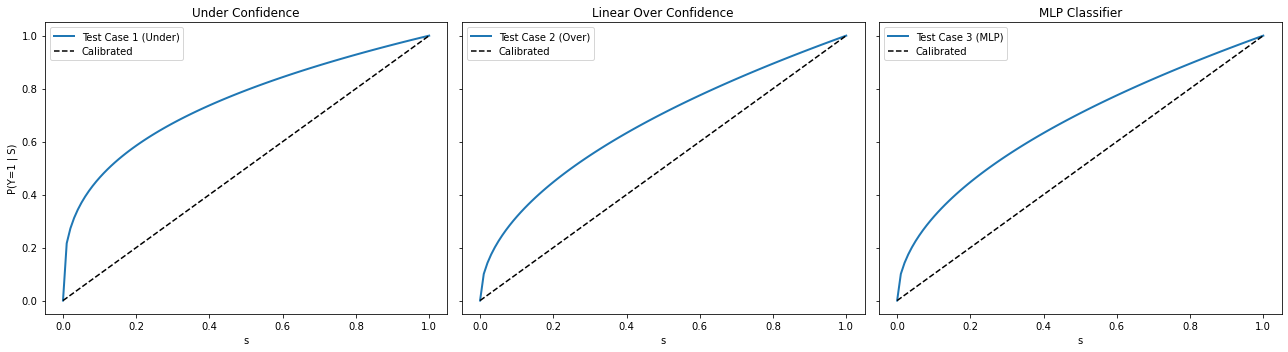

In [79]:
import numpy as np
import matplotlib.pyplot as plt

# Function to simulate underconfidence, overconfidence, and well-calibrated data
def generate_data(case, points=100):
    s = np.linspace(0, 1, points)
    if case == 'under':
        # Underconfident: true probability lags behind predicted
        p = np.power(s, 1/3)
    elif case == 'over':
        # Overconfident: true probability exceeds predicted until s=0.5 then lags
        p = np.sqrt(s)
    else:
        # Well-calibrated: true probability matches predicted
        p = s
    return s, p

# Generate data for each case
s_under, p_under = generate_data('under')
s_over, p_over = generate_data('over')
s_calibrated, p_calibrated = generate_data('calibrated')

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Underconfidence plot
axs[0].plot(s_under, p_under, label='Test Case 1 (Under)', linewidth=2)
axs[0].plot(s_calibrated, p_calibrated, 'k--', label='Calibrated')
axs[0].set_title('Under Confidence')
axs[0].set_xlabel('s')
axs[0].set_ylabel('P(Y=1 | S)')
axs[0].legend()

# Overconfidence plot
axs[1].plot(s_over, p_over, label='Test Case 2 (Over)', linewidth=2)
axs[1].plot(s_calibrated, p_calibrated, 'k--', label='Calibrated')
axs[1].set_title('Linear Over Confidence')
axs[1].set_xlabel('s')
axs[1].legend()

# MLP Classifier plot
axs[2].plot(s_over, p_over, label='Test Case 3 (MLP)', linewidth=2)
axs[2].plot(s_calibrated, p_calibrated, 'k--', label='Calibrated')
axs[2].set_title('MLP Classifier')
axs[2].set_xlabel('s')
axs[2].legend()

# Adjust plot
plt.tight_layout()
plt.show()

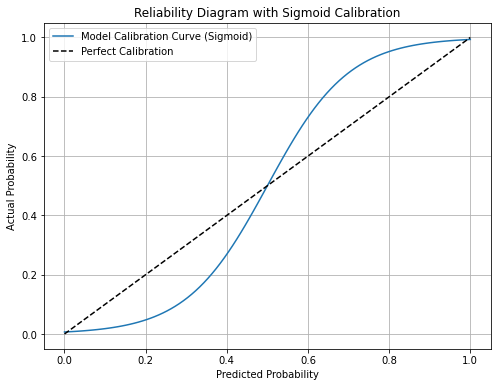

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Sigmoid function to model the probability mapping
def sigmoid(x):
    return 1 / (1 + np.exp(-10 * (x - 0.5)))

# Generating synthetic data for demonstration
predicted_probabilities = np.linspace(0, 1, 100)
actual_probabilities = sigmoid(predicted_probabilities)  # Sigmoid-shaped model calibration

plt.figure(figsize=(8, 6))
plt.plot(predicted_probabilities, actual_probabilities, label='Model Calibration Curve (Sigmoid)')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.title('Reliability Diagram with Sigmoid Calibration')
plt.legend()
plt.grid(True)
plt.show()

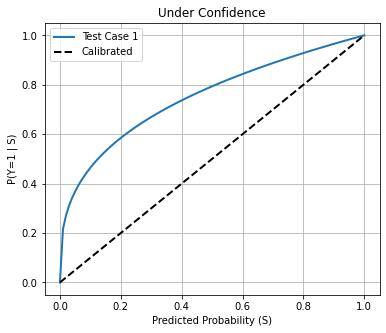

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Function to simulate underconfidence
def under_confident_curve(x):
    return np.power(x, 1/3)  # Adjusting the power can make it more or less underconfident

# Generating synthetic data for demonstration
predicted_probabilities = np.linspace(0, 1, 100)
under_confidence_probabilities = under_confident_curve(predicted_probabilities)  # Underconfident probabilities
perfect_calibration = predicted_probabilities  # Perfect calibration line

plt.figure(figsize=(6, 5))
plt.plot(predicted_probabilities, under_confidence_probabilities, label='Test Case 1', linewidth=2)
plt.plot(predicted_probabilities, perfect_calibration, 'k--', label='Calibrated', linewidth=2)
plt.xlabel('Predicted Probability (S)')
plt.ylabel('P(Y=1 | S)')
plt.title('Under Confidence')
plt.legend()
plt.grid(True)
plt.show()

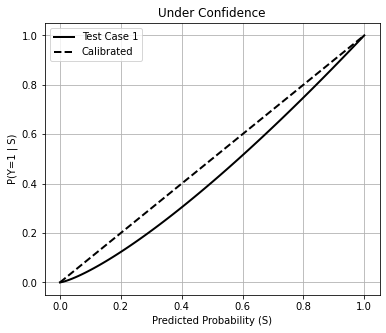

In [82]:
import matplotlib.pyplot as plt
import numpy as np

def modified_under_confident_curve(x):
    # Adjust the function to mimic the observed underconfidence
    return np.power(x, 1.3)  # Increase the exponent slightly for a more gradual rise

# Generating synthetic data for demonstration
predicted_probabilities = np.linspace(0, 1, 100)
under_confidence_probabilities = modified_under_confident_curve(predicted_probabilities)

plt.figure(figsize=(6, 5))
plt.plot(predicted_probabilities, under_confidence_probabilities, label='Test Case 1', linewidth=2, color='black')
plt.plot(predicted_probabilities, predicted_probabilities, 'k--', label='Calibrated', linewidth=2)
plt.xlabel('Predicted Probability (S)')
plt.ylabel('P(Y=1 | S)')
plt.title('Under Confidence')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
import numpy as np
import statsmodels.api as sm

# Simulated data
np.random.seed(0)
X = np.linspace(0, 10, 100)
y = 3 + 2 * X + np.random.normal(size=X.size)  # True model
weights = 1 / (1 + 0.1 * X**2)  # Example weights: lower weight to higher values of X

# Add a constant to X for the intercept
X = sm.add_constant(X)

# Fit a weighted least squares model
model = sm.WLS(y, X, weights=weights)
results = model.fit()

print(results.summary())


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            WLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     2028.
Date:                Tue, 06 Aug 2024   Prob (F-statistic):           2.73e-67
Time:                        09:45:12   Log-Likelihood:                -158.44
No. Observations:                 100   AIC:                             320.9
Df Residuals:                      98   BIC:                             326.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5500      0.162     21.968      0.0